# CNN-Transformer

## Dependences

In [ ]:
!nvidia-smi

Tue Apr 27 19:59:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install ffmpeg-python

In [ ]:
import os
import cv2
import ffmpeg
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import math
import glob
import random
from random import choice
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
!tar xzf '/content/drive/MyDrive/combined_ds.tar.gz'

CPU times: user 1.57 s, sys: 206 ms, total: 1.77 s
Wall time: 5min 8s


In [ ]:
%%time
!unrar x '/content/drive/MyDrive/CASIA_faceAntisp.rar'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/CASIA_faceAntisp.rar

You can download the datset from here : https://pan.baidu.com/s/15HyX7tizCCuwN9BKiV9_zA
Password: h5un
however, the labels are missing!

see https://github.com/mnikitin/Learn-Convolutional-Neural-Network-for-Face-Anti-Spoofing/issues/5#issuecomment-667916800

Creating    test_release                                              OK
Creating    test_release/18                                           OK
Extracting  test_release/18/1.avi                                          0%  OK 
Creating    train_release                                             OK
Creating    train_release/19                                          OK
Extracting  train_release/19/1.avi                                         0%  OK 
Creating    train_release/17                                          OK
Extracting  train_release/17/1.avi                           

In [ ]:
# %%time
# !gdown --id 1SB0qwhhlEFH1DZNeaFrsGEbYfWerRxWc

In [ ]:
# %%time
# !tar xzf combined_ds.tar.gz

In [ ]:
dir_1 = '/content/irina/attack/opt/labeler/static/video/api'
images_1 = glob.glob(dir_1 + '/*.*') + glob.glob(dir_1 + '/*/*.*')
len(images_1)

48

In [ ]:
dir_2 = '/content/irina/original/opt/labeler/static/video/api'
images_2 = glob.glob(dir_2 + '/*.*') + glob.glob(dir_2 + '/*/*.*')
len(images_2)

5092

In [ ]:
dir_3_4 = '/content/train_release/*/'
names_real = ['1', '2', 'HR_1']
names_fake = ['3', '4', '5', '6', '7', '8', 'HR_2', 'HR_3', 'HR_4']

In [ ]:
images_3 = []
for name in names_fake:
    images_3 += glob.glob(dir_3_4 + name + '.avi')
len(images_3)

180

In [ ]:
images_4 = []
for name in names_real:
    images_4 += glob.glob(dir_3_4 + name + '.avi')
len(images_4)

60

In [ ]:
train_threshold = len(images_1) + len(images_4) - 8
train_images = images_1[:40] + images_3 + images_2[:5052] + images_4
train_labels = [1 for i in range(train_threshold)] + [0 for i in range(len(train_images)-train_threshold)]
print(len(train_images))

5332


In [ ]:
val_images = images_1[-8:] + images_2[-40:]
val_labels = [1 for i in range(8)] + [0 for i in range(40)]
print(len(val_images))

48


## Preprocessing

In [ ]:
h, w = 224, 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
def check_rotation(path_video_file):

    meta_dict = ffmpeg.probe(path_video_file)

    rotateCode = None
    try:
        if int(meta_dict['streams'][0]['tags']['rotate']) == 90:
            rotateCode = cv2.ROTATE_90_CLOCKWISE
        elif int(meta_dict['streams'][0]['tags']['rotate']) == 180:
            rotateCode = cv2.ROTATE_180
        elif int(meta_dict['streams'][0]['tags']['rotate']) == 270:
            rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE
    except: 
        pass
        
    return rotateCode

In [ ]:
def correct_rotation(frame, rotateCode):  
    return cv2.rotate(frame, rotateCode)

In [ ]:
def get_frames(filename, n_max=float('inf')):
    
    frames = []
    v_cap = cv2.VideoCapture(filename)
    rotateCode = check_rotation(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    n_frames = min(v_len, n_max)
    frame_list= np.linspace(0, v_len-1, n_frames, dtype=np.int16)

    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            continue
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if rotateCode is not None:
                frame = correct_rotation(frame, rotateCode)  
            frames.append(frame)

    v_cap.release()

    return frames, len(frames)

In [ ]:
def transform_frames(frames, train=True):

    img_transforms_0 = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])
    img_transforms_1 = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.Grayscale(num_output_channels=3),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])
    img_transforms_2 = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.RandomHorizontalFlip(p=1.),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])
    img_transforms_3 = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.Grayscale(num_output_channels=3),
                transforms.RandomHorizontalFlip(p=1.),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])
    
    img_transforms = [img_transforms_0, 
                      img_transforms_1, 
                      img_transforms_2, 
                      img_transforms_3] 
    if train:
        img_transform = random.choice(img_transforms)
    else:
        img_transform = img_transforms_0
    
    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)       
        frame_tr = img_transform(frame)
        frames_tr.append(frame_tr)
        
    imgs_tensor = torch.stack(frames_tr)    

    return imgs_tensor

## Model

In [ ]:
class CNNEncoder(nn.Module):

    def __init__(self, pretrained=True):
        super(CNNEncoder, self).__init__()
        
        resnet = models.resnet34(pretrained=pretrained) 

        # Удаляем последний линейный слой
        # На выходе будем получать тензор (batch_size, 512, 1, 1)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

    def forward(self, image):

        # (batch_size, 512, 1, 1)
        out = self.resnet(image)

        return out

In [ ]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
class CNN_Transformer(nn.Module):
    
    def __init__(self, num_classes, nlayers, hidden, nhead, dim_feedforward, dropout=0, activation='relu'):

        super(CNN_Transformer, self).__init__()

        self.hidden = hidden
        
        # CNN
        self.cnn = CNNEncoder()
        self.conv = nn.Conv2d(512, hidden, 1)

        # Transformer
        self.pos = PositionalEncoding(hidden) 
        encoder_layer = nn.TransformerEncoderLayer(hidden, 
                                                   nhead, 
                                                   dim_feedforward, 
                                                   dropout, 
                                                   activation)
        encoder_norm = nn.LayerNorm(hidden)
        self.transformer = nn.TransformerEncoder(encoder_layer, 
                                                 nlayers, 
                                                 encoder_norm)

        # Classifier
        self.dropout= nn.Dropout(dropout)
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, frames, mask=None):

        bs, s, c, height, width = frames.shape
        frames_emb = torch.zeros(s, bs, self.hidden).to(device)

        for i in range(s):
            img_emb = self.cnn(frames[:, i])
            img_emb = torch.relu(self.conv(img_emb))
            frames_emb[i] = img_emb.view(bs, -1)

        frames_emb = self.pos(frames_emb) 
        out = self.transformer(src=frames_emb, src_key_padding_mask=mask)
        out = self.fc(torch.max(self.dropout(out), 0)[0])
 
        return out

## Configuration

In [ ]:
model = CNN_Transformer(num_classes=2, 
                        nlayers=1, 
                        hidden=32, 
                        nhead=4, 
                        dim_feedforward=128, 
                        dropout=0.5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
model = model.to(device)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 0.00005)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=1, 
                                            gamma=0.5)

In [ ]:
max_epochs = 1000
every_epochs = 100
n_max = 40
clip = 3

## Training

In [ ]:
def generate_batch(images, labels, batch_size, threshold=None, size=None, train=True, n_max=30):
    
    if train:
        if size is None:
            size = batch_size // 2
        if threshold is None:
            threshold = sum(labels)
        n = random.randint(max(1, n_max-10), n_max+10)
        index_1 = np.random.randint(0, threshold, size=size)
        index_2 = np.random.randint(threshold, len(images), size=batch_size-size)
        random_index = np.concatenate((index_1, index_2))
        np.random.shuffle(random_index)
        filenames = np.array(images)[random_index]
        batch_labels = np.array(labels)[random_index]
    else:
        n = n_max
        filenames = np.array(images)
        batch_labels = np.array(labels)

    batch_images = []
    f_lens = []

    for filename in filenames:
        frames, f_len = get_frames(filename, n_max=n)
        f_lens.append(f_len)
        img_tensor = transform_frames(frames, train)
        batch_images.append(img_tensor)

    max_len = np.max(f_lens)

    _, c, h, w = batch_images[0].shape
    batch_images_padded = torch.zeros((batch_size, max_len, c, h, w)) 
    mask = [] 

    for i, img in enumerate(batch_images):

        batch_images_padded[i, :f_lens[i], :, :, :] = img
        mask.append([False for j in range(f_lens[i])] + [True for j in range(max_len-f_lens[i])])
    
    return batch_images_padded, torch.LongTensor(batch_labels), torch.LongTensor(f_lens), torch.tensor(mask)

In [ ]:
def evaluate(model, criterion, val_images, val_labels, batch_size):
    
    model.eval()
    
    epoch_loss = 0
    f1 = 0
    outputs = []

    # Не учитываем последний неполный батч
    val_size = len(val_images) // batch_size * batch_size
    
    with torch.no_grad():
    
        for i in range(0, val_size, batch_size):

            batch = generate_batch(val_images[i:i+batch_size], 
                                   val_labels[i:i+batch_size], 
                                   batch_size=16, 
                                   train=False)
            labels = batch[1].to(device)
        
            output = model(batch[0].to(device), batch[3].to(device))

            loss = criterion(output, labels)
            outputs += output.argmax(-1).tolist()
            
            epoch_loss += loss.item()
    
    f1 = f1_score(val_labels, outputs)
    conf_matrix = confusion_matrix(val_labels, outputs)
    roc_auc = roc_auc_score(val_labels, outputs)
        
    return epoch_loss / (val_size // batch_size), f1, conf_matrix, roc_auc

Epoch : 100
Train loss : 0.24478895436041057
Val loss   : 0.27321555217107135
Val f1     : 0.888888888888889
Val roc auc: 0.975
Conf matrix:
[[38  2]
 [ 0  8]]
Save best loss model
Save best score model

Epoch : 200
Train loss : 0.049673620029352605
Val loss   : 0.19631140182415643
Val f1     : 0.9411764705882353
Val roc auc: 0.9874999999999999
Conf matrix:
[[39  1]
 [ 0  8]]
Save best loss model
Save best score model

Epoch : 300
Train loss : 0.027387208819855003
Val loss   : 0.2016934504111608
Val f1     : 0.9333333333333333
Val roc auc: 0.9375
Conf matrix:
[[40  0]
 [ 1  7]]

Epoch : 400
Train loss : 0.014874811803456395
Val loss   : 0.17378521462281546
Val f1     : 0.9333333333333333
Val roc auc: 0.9375
Conf matrix:
[[40  0]
 [ 1  7]]
Save best loss model

Epoch : 500
Train loss : 0.018693473530001937
Val loss   : 0.21185955653587976
Val f1     : 0.7999999999999999
Val roc auc: 0.8625
Conf matrix:
[[39  1]
 [ 2  6]]

Epoch : 600
Train loss : 0.010015255457255989
Val loss   : 0.1936

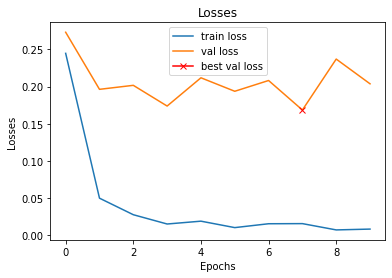

CPU times: user 1h 52min 28s, sys: 26min 57s, total: 2h 19min 26s
Wall time: 2h 4min 37s


In [ ]:
%%time
best_f1 = 0
best_loss = float('inf')
epoch_loss = 0
train_losses = []
val_losses = []

for epoch in range(1, max_epochs+1):

    batch = generate_batch(images=train_images, 
                           labels=train_labels, 
                           batch_size=8, 
                           threshold=train_threshold, 
                           size=4, 
                           train=True, 
                           n_max=n_max)
    labels = batch[1].to(device)
    model.train()
    optimizer.zero_grad()
        
    outputs = model(batch[0].to(device), batch[3].to(device))

    loss = criterion(outputs, labels)        
    loss.backward()       
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)       
    optimizer.step()       
    epoch_loss += loss.item()

    if epoch % every_epochs == 0:
        scheduler.step()
        
        val_loss, val_f1, conf_matrix, val_roc_auc = evaluate(model, 
                                                              criterion, 
                                                              val_images, 
                                                              val_labels, 
                                                              batch_size=16)   
        print('Epoch : {}'.format(epoch))
        print('Train loss : {}'.format(epoch_loss / every_epochs))
        print('Val loss   : {}'.format(val_loss))
        print('Val f1     : {}'.format(val_f1))
        print('Val roc auc: {}'.format(val_roc_auc))
        print('Conf matrix:')
        print(conf_matrix)
        
        train_losses.append(epoch_loss / every_epochs)
        val_losses.append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), '/content/v2_CNN_Transformer_best_loss.pt')
            print('Save best loss model')
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), '/content/v2_CNN_Transformer_best_score.pt')
            print('Save best score model')
        epoch_loss = 0
        print()

plt.title("Losses")
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.plot(np.argmin(val_losses), np.min(val_losses), marker="x", color="r", label="best val loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()